In [7]:
# 1. Install osmium-tool (macOS)
# If you don't have Homebrew, install it from https://brew.sh/
# !brew install osmium-tool

In [8]:
# 2. Download Planet PBF
# WARNING: This file is HUGE (~70GB). Ensure you have enough space and bandwidth.
# We use curl with -C - to allow resuming downloads.
# Added -L to follow redirects (planet-latest points to a specific date).

# Uncomment the line below to start the download:
# !curl -L -C - -o planet-latest.osm.pbf https://planet.openstreetmap.org/pbf/planet-latest.osm.pbf

In [9]:
# 3. Filter for wheelchair tags
# This command filters ONLY nodes (n) that have the 'wheelchair' key.
# It saves the result to a much smaller PBF file.

# Uncomment to run (after downloading the planet file):
# !osmium tags-filter planet-latest.osm.pbf n/wheelchair -o planet-wheelchair.osm.pbf --overwrite

In [10]:
# 4. Export to GeoJSON (Optional)
# This converts the filtered PBF to GeoJSON for easier use in Python/JS.
# Note: The resulting GeoJSON might still be quite large.

# Uncomment to run:
# !osmium export planet-wheelchair.osm.pbf -o planet-wheelchair.geojson --overwrite

====

In [ ]:
import json

# Load the JSON data
with open('osm_data_cache_-90_-180_90_180.json', 'r') as f:
    osm_wheelchair_data = json.load(f)

: 

In [ ]:
import pandas as pd

from tqdm import tqdm
import os

csv_file = 'osm_wheelchair_data.csv'

# Load JSON data to check total elements
elements = osm_wheelchair_data['elements']
total = len(elements)

# Check if CSV already exists and is complete
if os.path.exists(csv_file):
    print(f"Found existing CSV file: {csv_file}")
    osm_wheelchair = pd.read_csv(csv_file)
    existing_rows = len(osm_wheelchair)
    print(f"Existing rows: {existing_rows}, Target rows: {total}")
    
    if existing_rows >= total:
        print(f"CSV is complete! Loaded DataFrame shape: {osm_wheelchair.shape}")
    else:
        print(f"CSV is incomplete. Resuming from row {existing_rows}...")
        chunk_size = 10000
        
        # Resume processing from where we left off
        for i in tqdm(range(existing_rows, total, chunk_size), desc="Resuming DataFrame conversion"):
            chunk = elements[i:min(i + chunk_size, total)]
            df_chunk = pd.json_normalize(chunk)
            
            # Append chunks to CSV
            df_chunk.to_csv(csv_file, index=False, mode='a', header=False)
            osm_wheelchair = pd.concat([osm_wheelchair, df_chunk], ignore_index=True)
        
        print(f"\nResumed and completed! Final DataFrame shape: {osm_wheelchair.shape}")
else:
    print("CSV not found. Processing JSON data from scratch...")
    print(f"Total elements: {total}")
    
    chunk_size = 10000  # Process 10k elements at a time
    osm_wheelchair = None
    
    for i in tqdm(range(0, total, chunk_size), desc="Converting to DataFrame"):
        chunk = elements[i:min(i + chunk_size, total)]
        df_chunk = pd.json_normalize(chunk)
        
        if osm_wheelchair is None:
            osm_wheelchair = df_chunk
            # Write header and first chunk
            osm_wheelchair.to_csv(csv_file, index=False, mode='w')
        else:
            # Append subsequent chunks without header
            df_chunk.to_csv(csv_file, index=False, mode='a', header=False)
            osm_wheelchair = pd.concat([osm_wheelchair, df_chunk], ignore_index=True)
    
    print(f"\nFinal DataFrame shape: {osm_wheelchair.shape}")

osm_wheelchair.info()
osm_wheelchair.head()

CSV not found. Processing JSON data from scratch...
Total elements: 2449259


Converting to DataFrame:  49%|████▉     | 120/245 [2:16:48<15:50:55, 456.45s/it]

In [ ]:
# Filter for Ukraine
# Ukraine bounding box: lat 44.3° to 52.4° N, lon 22.1° to 40.2° E
ukraine_osm_wheelchair = osm_wheelchair[
    (osm_wheelchair['lat'] >= 44.3) & (osm_wheelchair['lat'] <= 52.4) &
    (osm_wheelchair['lon'] >= 22.1) & (osm_wheelchair['lon'] <= 40.2)
]

print(f"Total records: {len(osm_wheelchair)}")
print(f"Ukraine records: {len(ukraine_osm_wheelchair)}")
print(f"Percentage: {len(ukraine_osm_wheelchair) / len(osm_wheelchair) * 100:.2f}%")

ukraine_osm_wheelchair.head()

In [ ]:
osm_wheelchair.describe()

,id,lat,lon
count,2.449200e+04,24492.000000,24492.000000
mean,6.829335e+09,-37.673992,88.986524
std,4.083103e+09,5.121046,99.910732
min,1.792224e+07,-85.051132,-90.727972
25%,3.473717e+09,-37.953165,-58.421752
50%,6.238015e+09,-37.676822,144.971637
75%,1.085739e+10,-34.630749,150.744936
max,1.334868e+10,-32.234983,178.369600


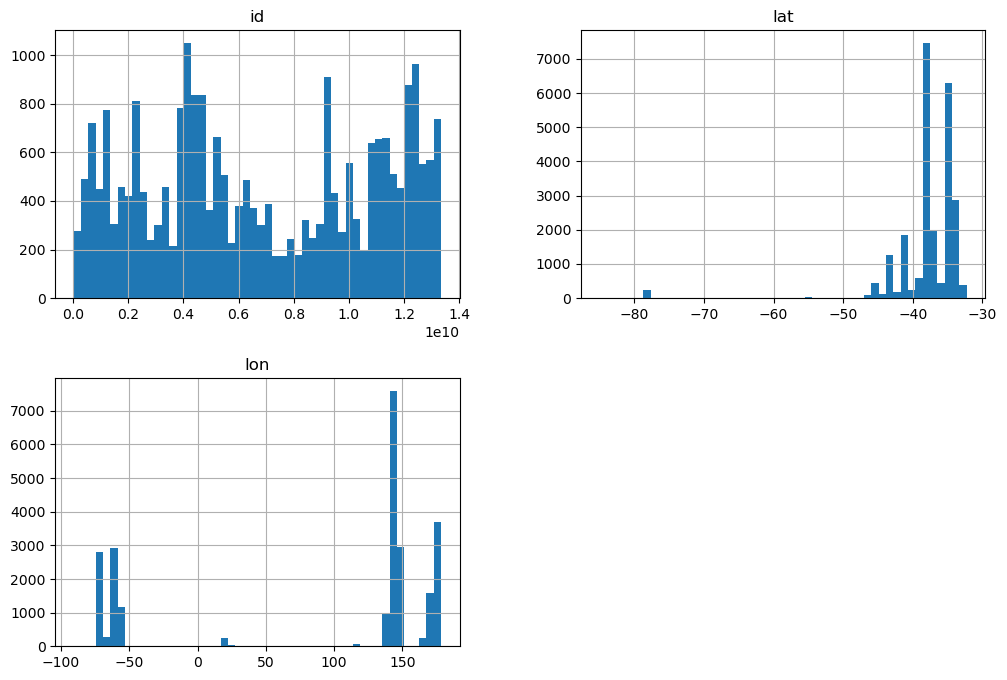

In [ ]:
import matplotlib.pyplot as plt
osm_wheelchair.hist(bins=50, figsize=(12, 8))
plt.show()